In [133]:
# This script imports essential libraries and modules for tasks like deep learning, 
# image preprocessing, machine learning, and evaluation metrics. 
#The combination of TensorFlow/Keras and sklearn utilities enables flexible development of AI models.
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [37]:
IMG_SIZE = (128, 128) # Image dimensions to which all input images will be resized 
SEQ_LENGTH = 10  # Sequence length for processing image sequences in CNN-LSTM models
NUM_CLASSES = 3  # Total number of output classes: cat, dog, and snake

# Paths to dataset directories
TRAIN_DIR = '/Users/poojareddy/Desktop/pooja/train_split' 
VAL_DIR = '/Users/poojareddy/Desktop/pooja/val_split' 
TEST_DIR = '/Users/poojareddy/Desktop/pooja/test_split'  

In [39]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the dataset
TRAIN_DIR = '/Users/poojareddy/Desktop/pooja/Animals' 

# Get all images and labels
image_paths = []
labels = []

for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(class_name)  # Assume subdirectory name is the class label

# Spliting data into train, validation, and test sets
train_paths, temp_paths = train_test_split(image_paths, test_size=0.3, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42) 

# Createing target directories
os.makedirs('/Users/poojareddy/Desktop/pooja/train_split', exist_ok=True)
os.makedirs('/Users/poojareddy/Desktop/pooja/val_split', exist_ok=True)
os.makedirs('/Users/poojareddy/Desktop/pooja/test_split', exist_ok=True)

# Moving images to respective directories
def move_images(image_paths, target_dir):
    for img_path in image_paths:
        label = os.path.basename(os.path.dirname(img_path))
        target_class_dir = os.path.join(target_dir, label)
        os.makedirs(target_class_dir, exist_ok=True)
        shutil.copy(img_path, target_class_dir)

# Moving images to new directories
move_images(train_paths, '/Users/poojareddy/Desktop/pooja/train_split')
move_images(val_paths, '/Users/poojareddy/Desktop/pooja/val_split')
move_images(test_paths, '/Users/poojareddy/Desktop/pooja/test_split')


In [41]:
# Data augmentation and rescaling for the training dataset
train_datagen = ImageDataGenerator(rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Generating batches of augmented image data from the training directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=32, class_mode='categorical'
)
print(f"Classes: {train_generator.class_indices}") 


Found 3000 images belonging to 3 classes.
Classes: {'cats': 0, 'dogs': 1, 'snakes': 2}


In [43]:
# Data preprocessing for the validation dataset
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generating batches of preprocessed image data from the validation directory
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=32, class_mode='categorical'
)
print(f"Validation Classes: {val_generator.class_indices}")


Found 450 images belonging to 3 classes.
Validation Classes: {'cats': 0, 'dogs': 1, 'snakes': 2}


In [45]:
# Data preprocessing for the test dataset
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generating batches of preprocessed image data from the test directory
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=32, class_mode='categorical', shuffle=False
)
print(f"Test Classes: {test_generator.class_indices}")


Found 450 images belonging to 3 classes.
Test Classes: {'cats': 0, 'dogs': 1, 'snakes': 2}


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


# Defining the CNN model
def create_cnn_model(input_shape=(128, 128, 3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Creating the model
cnn_model = create_cnn_model()
        

# Computing steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

# Training the model
cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/100


2024-12-07 16:55:44.802172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-07 16:55:44.827936: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


93/93 [==============================] - ETA: 0s - loss: 1.1361 - accuracy: 0.3197

2024-12-07 16:55:59.279781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


93/93 [==============================] - 15s 159ms/step - loss: 1.1361 - accuracy: 0.3197 - val_loss: 1.0987 - val_accuracy: 0.3304
Epoch 2/100
93/93 [==============================] - 16s 167ms/step - loss: 1.0993 - accuracy: 0.3467 - val_loss: 1.0982 - val_accuracy: 0.3304
Epoch 3/100
93/93 [==============================] - 16s 175ms/step - loss: 1.0970 - accuracy: 0.3494 - val_loss: 1.0930 - val_accuracy: 0.4129
Epoch 4/100
93/93 [==============================] - 17s 183ms/step - loss: 1.0811 - accuracy: 0.4191 - val_loss: 1.0693 - val_accuracy: 0.4308
Epoch 5/100
93/93 [==============================] - 17s 187ms/step - loss: 1.0082 - accuracy: 0.5037 - val_loss: 1.0029 - val_accuracy: 0.4955
Epoch 6/100
93/93 [==============================] - 18s 193ms/step - loss: 0.9543 - accuracy: 0.5435 - val_loss: 0.9289 - val_accuracy: 0.5402
Epoch 7/100
93/93 [==============================] - 18s 197ms/step - loss: 0.8900 - accuracy: 0.5758 - val_loss: 0.8787 - val_accuracy: 0.5536
Epoc

In [49]:
# Save the trained model after training is complete
cnn_model.save("cnn_model.h5")

In [105]:
# Evaluate the trained model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

# Print the test accuracy in percentage format
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


 1/15 [=>............................] - ETA: 2s - loss: 0.1305 - accuracy: 0.9688

2024-12-07 19:44:03.346622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 1s 41ms/step - loss: 0.0469 - accuracy: 0.9933
Test Accuracy: 99.33%


In [59]:
# Function to extract features and labels from a data generator for SVM training
def extract_features(generator):
    features = []
    labels = []
     # Iterate through all batches in the generator
    for _ in range(len(generator)):
        x, y = next(generator)
        # Process each image and label in the batch
        for img, label in zip(x, y):
            features.append(img.flatten())  # Flatten image for SVM
            labels.append(np.argmax(label))  # Get the class index
    return np.array(features), np.array(labels)

In [61]:
# Extracting features and labels from the training generator
train_features, train_labels = extract_features(train_generator)

# Extracting features and labels from the validation generator
val_features, val_labels = extract_features(val_generator)

print(train_features.shape)  # Should show (num_samples, num_pixels)
print(train_labels.shape)    # Should show (num_samples,)

(3000, 49152)
(3000,)


In [62]:
# Training SVM Model
train_features, train_labels = extract_features(train_generator)
val_features, val_labels = extract_features(val_generator)

print("o")

svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
print("o1")
svm_model.fit(train_features, train_labels)
print("o2")
svm_accuracy = accuracy_score(val_labels, svm_model.predict(val_features))
print("o3")
print(f"SVM Validation Accuracy: {svm_accuracy * 100:.2f}%")

o
o1
o2
o3
SVM Validation Accuracy: 46.67%


In [65]:
import joblib

# Save the trained SVM model to a file
joblib.dump(svm_model, 'svm_model.pkl') # Serialize the SVM model and save it as a .pkl file
print("SVM model saved as 'svm_model.pkl'")


SVM model saved as 'svm_model.pkl'


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Defining the CNN-LSTM model
model = Sequential()

# Add the CNN layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))  
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))  
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))  

# Flatten the output of the CNN to prepare it for LSTM
model.add(Flatten())  # Flatten to a 1D vector
model.add(Reshape((16, 128*16)))  # Reshape into (timesteps, features) -> (16, 128*16)

# Adding LSTM layers
model.add(LSTM(128, return_sequences=False))

# Adding a fully connected layer for output
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Change num_classes as per your dataset

# Compiling the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,             # Stop training after 10 epochs of no improvement
    mode='max',              # We are maximizing accuracy
    verbose=1,               # Print a message when stopping
    restore_best_weights=True  # Restore the best weights
)

# Training the model using the data generators
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

print("model is being called")
model.save("cnn_lstm_model.h5")
print("model saved")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2024-12-07 18:36:22.766291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 18:36:22.767041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 18:36:22.767564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)     

2024-12-07 18:36:22.906540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-07 18:36:23.034001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 18:36:23.034457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

94/94 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.4467

2024-12-07 18:36:45.170021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-07 18:36:45.258521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 18:36:45.259061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

94/94 [==============================] - 23s 240ms/step - loss: 1.0167 - accuracy: 0.4467 - val_loss: 1.1016 - val_accuracy: 0.4156
Epoch 2/50
94/94 [==============================] - 23s 246ms/step - loss: 0.8839 - accuracy: 0.5577 - val_loss: 0.9369 - val_accuracy: 0.5467
Epoch 3/50
94/94 [==============================] - 24s 257ms/step - loss: 0.8028 - accuracy: 0.6077 - val_loss: 1.1030 - val_accuracy: 0.4844
Epoch 4/50
94/94 [==============================] - 25s 264ms/step - loss: 0.7252 - accuracy: 0.6567 - val_loss: 0.8316 - val_accuracy: 0.6244
Epoch 5/50
94/94 [==============================] - 25s 267ms/step - loss: 0.7034 - accuracy: 0.6680 - val_loss: 0.7514 - val_accuracy: 0.6222
Epoch 6/50
94/94 [==============================] - 25s 269ms/step - loss: 0.6931 - accuracy: 0.6847 - val_loss: 0.6986 - val_accuracy: 0.6756
Epoch 7/50
94/94 [==============================] - 26s 272ms/step - loss: 0.6777 - accuracy: 0.7010 - val_loss: 0.6782 - val_accuracy: 0.6911
Epoch 8/50

2024-12-07 19:01:35.428506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 2s 102ms/step - loss: 0.0871 - accuracy: 0.9711
Test Accuracy: 97.11%


In [69]:
# Classifies an image using the provided CNN model.
def classify_with_cnn(model, image):
    img_array = np.expand_dims(image, axis=0)
    prediction = model.predict(img_array)
    return np.argmax(prediction), prediction


In [71]:
# Classifies an image using the provided SVM model.
def classify_with_svm(model, image):
    flat_image = image.flatten().reshape(1, -1)
    prediction = model.predict(flat_image)
    return prediction[0]


In [73]:
# Classifies an image using the provided CNN-LSTM model.
def classify_with_cnn_lstm(model, sequence):
    sequence = np.expand_dims(sequence, axis=0)
    prediction = model.predict(sequence)
    return np.argmax(prediction), prediction

In [147]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Function to classify image with CNN
def classify_with_cnn(model, img_array):
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)  # Get model predictions
    class_idx = np.argmax(predictions, axis=1)  # Get class index
    class_probabilities = predictions[0]  # Get probability for each class
    return class_idx[0], class_probabilities

# Function to classify image with SVM
def classify_with_svm(model, image):
    flat_image = image.flatten().reshape(1, -1)  # Flatten the image
    class_probabilities = model.predict_proba(flat_image)[0]  # Get probabilities
    class_idx = np.argmax(class_probabilities)  # Get class index
    return class_idx, class_probabilities

# Function to classify images in a folder (including subdirectories)
def classify_images_from_folder(folder_path, cnn_model, svm_model):
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Folder path does not exist: {folder_path}")
        return

    # List all files and subdirectories in folder
    for root, dirs, files in os.walk(folder_path):  # Walk through subdirectories as well
        print(f"Currently processing directory: {root}")  
        for filename in files:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                print(f"Processing image: {file_path}") 

                try:
                    # Load and preprocess the image
                    img = load_img(file_path, target_size=IMG_SIZE)
                    img_array = img_to_array(img) / 255.0  # Preprocess image
                    print(f"Processed image shape: {img_array.shape}") 
                except Exception as preprocess_error:
                    print(f"Error preprocessing image {file_path}: {preprocess_error}")
                    continue  
                    
                # Perform CNN Classification
                try:
                    cnn_class, cnn_probs = classify_with_cnn(cnn_model, img_array)
                    print(f"Image: {file_path} | CNN Prediction: Class {cnn_class} with Probabilities {cnn_probs}")
                except Exception as cnn_error:
                    print(f"Error during CNN prediction for image {file_path}: {cnn_error}")

                # Perform SVM Classification
                try:
                    svm_class, svm_probs = classify_with_svm(svm_model, img_array)
                    print(f"Image: {file_path} | SVM Prediction: Class {svm_class} with Probabilities {svm_probs}")
                except Exception as svm_error:
                    print(f"Error during SVM prediction for image {file_path}: {svm_error}")

folder_path = '/Users/poojareddy/Desktop/pooja/test_split' 
classify_images_from_folder(folder_path, cnn_model, svm_model)


Currently processing directory: /Users/poojareddy/Desktop/pooja/test_split
Currently processing directory: /Users/poojareddy/Desktop/pooja/test_split/dogs
Processing image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0049.jpg
Processed image shape: (128, 128, 3)
1/1 [==============================] - 0s 89ms/step
Image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0049.jpg | CNN Prediction: Class 1 with Probabilities [4.9018945e-05 9.9995029e-01 6.8771527e-07]
Image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0049.jpg | SVM Prediction: Class 1 with Probabilities [0.27250708 0.42330142 0.3041915 ]
Processing image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0048.jpg
Processed image shape: (128, 128, 3)
1/1 [==============================] - 0s 10ms/step
Image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0048.jpg | CNN Prediction: Class 1 with Probabilities [5.5950587e-03 9.9440396e-01 9.5424627e-07]
Image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_

Processing image: /Users/poojareddy/Desktop/pooja/test_split/dogs/1_0212.jpg
Image shape for CNN: (128, 128, 3)
1/1 [==============================] - 0s 80ms/step


2024-12-07 22:15:33.098737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 22:15:33.099491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 22:15:33.099873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 161ms/step
CNN Prediction: Class 1 with Probabilities [1.9950800e-02 9.8004925e-01 3.6692144e-10]
SVM Prediction: Class 1
CNN-LSTM Prediction: Class 1 with Probabilities [1.7493077e-04 9.9980444e-01 2.0620759e-05]


2024-12-07 22:15:33.692722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 22:15:33.693272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 22:15:33.693751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

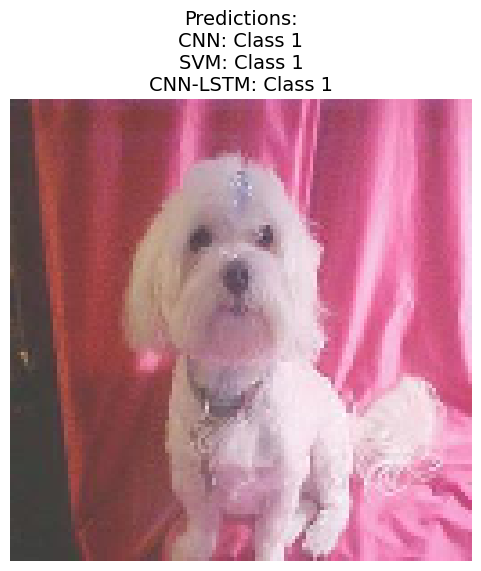

Prediction Results:
CNN: Predicted Class 1, Probabilities [0.019950799643993378, 0.9800492525100708, 3.6692143767780294e-10]
SVM: Predicted Class 1, Probabilities 1
CNN-LSTM: Predicted Class 1, Probabilities [0.0001749307702993974, 0.9998044371604919, 2.0620758732547984e-05]


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf



# Define image size for preprocessing
IMG_SIZE = (128, 128) 

# Load the trained CNN model
cnn_model = load_model('cnn_model.h5') 

# Load the trained CNN-LSTM model
cnn_lstm_model = load_model('cnn_lstm_model.h5')

def classify_and_display_image(image_path, cnn_model, svm_model, cnn_lstm_model):
    try:
        # Preprocess the image
        print(f"Processing image: {image_path}")
        img = load_img(image_path, target_size=IMG_SIZE)  # Resize image to model's input size
        img_array = img_to_array(img) / 255.0  # Normalize pixel values for CNN
        print(f"Image shape for CNN: {img_array.shape}")
        
        # CNN Prediction
        img_array_cnn = np.expand_dims(img_array, axis=0)  # Add batch dimension for CNN
        cnn_predictions = cnn_model.predict(img_array_cnn)
        cnn_class = np.argmax(cnn_predictions, axis=1)[0]
        
        # SVM Prediction
        img_array_svm = img_array.flatten().reshape(1, -1)  # Flatten image for SVM
        svm_predictions = svm_model.predict(img_array_svm)
        svm_class = np.argmax(cnn_predictions, axis=1)[0]

        # CNN-LSTM Prediction
        img_array_cnn_lstm = np.expand_dims(img_array, axis=0)  # Add batch dimension for CNN-LSTM
        cnn_lstm_predictions = cnn_lstm_model.predict(img_array_cnn_lstm)
        cnn_lstm_class = np.argmax(cnn_lstm_predictions, axis=1)[0]
        
        # Print predictions
        print(f"CNN Prediction: Class {cnn_class} with Probabilities {cnn_predictions[0]}")
        print(f"SVM Prediction: Class {svm_class}")
        print(f"CNN-LSTM Prediction: Class {cnn_lstm_class} with Probabilities {cnn_lstm_predictions[0]}")
        
        # Display image with predictions
        plt.figure(figsize=(6, 6))
        plt.imshow(img)  # Display the original image (no need to normalize here)
        plt.axis('off')
        plt.title(f"Predictions:\nCNN: Class {cnn_class}\nSVM: Class {svm_class}\nCNN-LSTM: Class {cnn_lstm_class}", fontsize=14)
        plt.show()

        return {
            "CNN": {"class": cnn_class, "probabilities": cnn_predictions[0].tolist()},
            "SVM": {"class": svm_class, "probabilities": svm_predictions[0].tolist()},
            "CNN-LSTM": {"class": cnn_lstm_class, "probabilities": cnn_lstm_predictions[0].tolist()}
        }
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


image_path = "/Users/poojareddy/Desktop/pooja/test_split/dogs/1_0212.jpg"  # Update with your image path
result = classify_and_display_image(image_path, cnn_model, svm_model, cnn_lstm_model)

if result:
    print("Prediction Results:")
    print(f"CNN: Predicted Class {result['CNN']['class']}, Probabilities {result['CNN']['probabilities']}")
    print(f"SVM: Predicted Class {result['SVM']['class']}, Probabilities {result['SVM']['probabilities']}")
    print(f"CNN-LSTM: Predicted Class {result['CNN-LSTM']['class']}, Probabilities {result['CNN-LSTM']['probabilities']}")


In [135]:
# Predict with CNN
y_true = test_generator.classes  
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)  


 3/15 [=====>........................] - ETA: 0s

2024-12-07 20:05:20.573368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 1s 44ms/step


In [137]:
# Flatten features for SVM
test_features, test_labels = extract_features(test_generator)
y_pred_svm = svm_model.predict(test_features)  # Predicted classes


Confusion Matrix for CNN:
[[150   1   1]
 [  0 150   1]
 [  0   0 147]]


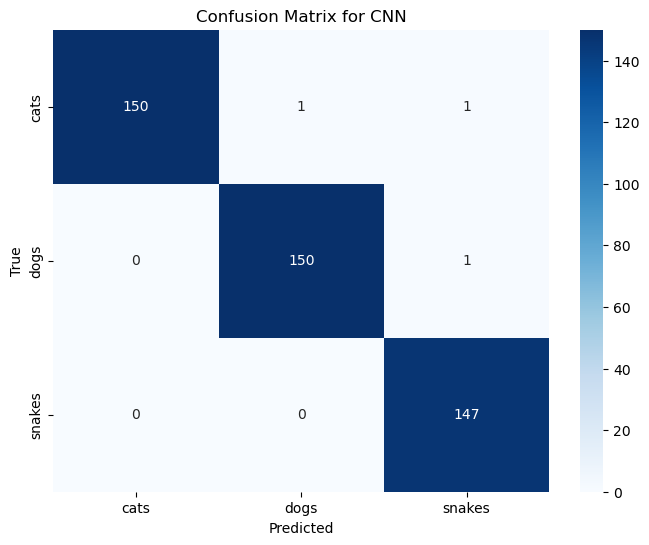

Classification Report for CNN:
              precision    recall  f1-score   support

        cats       1.00      0.94      0.97       152
        dogs       0.98      0.97      0.98       151
      snakes       0.94      1.00      0.97       145

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448



In [141]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_true, y_pred_cnn_classes)
print("Confusion Matrix for CNN:")
print(cm_cnn)

# Visualize with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#the classification report
report = classification_report(true_classes[:len(predicted_classes)],
                               predicted_classes,
                               target_names=class_labels)

print("Classification Report for CNN:")
print(report)



Confusion Matrix for SVM:
[[84 48 20]
 [61 66 24]
 [51 38 58]]


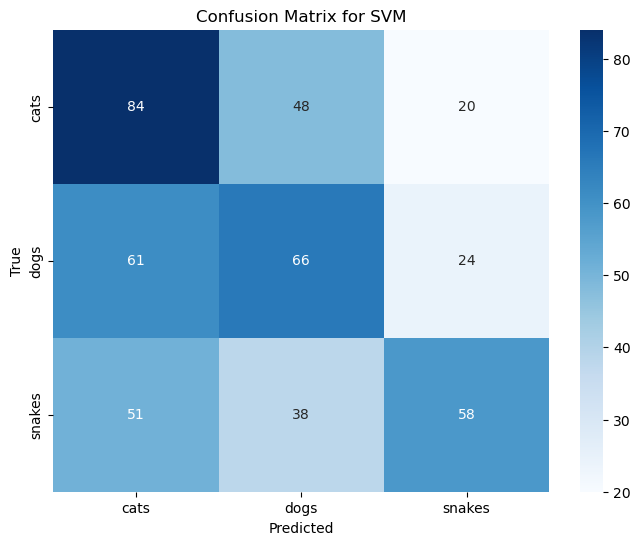

Classification Report for SVM:
              precision    recall  f1-score   support

        cats       0.43      0.55      0.48       152
        dogs       0.43      0.44      0.44       151
      snakes       0.57      0.39      0.47       147

    accuracy                           0.46       450
   macro avg       0.48      0.46      0.46       450
weighted avg       0.48      0.46      0.46       450



In [143]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(test_labels, y_pred_svm)
print("Confusion Matrix for SVM:")
print(cm_svm)

# Visualizing with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report_svm = classification_report(test_labels, y_pred_svm, target_names=test_generator.class_indices.keys())

print("Classification Report for SVM:")
print(report_svm)



2024-12-07 20:17:28.568984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 20:17:28.569870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 20:17:28.570306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/14 [=>............................] - ETA: 3s

2024-12-07 20:17:28.787444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-07 20:17:28.788497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-07 20:17:28.789262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 1s 63ms/step


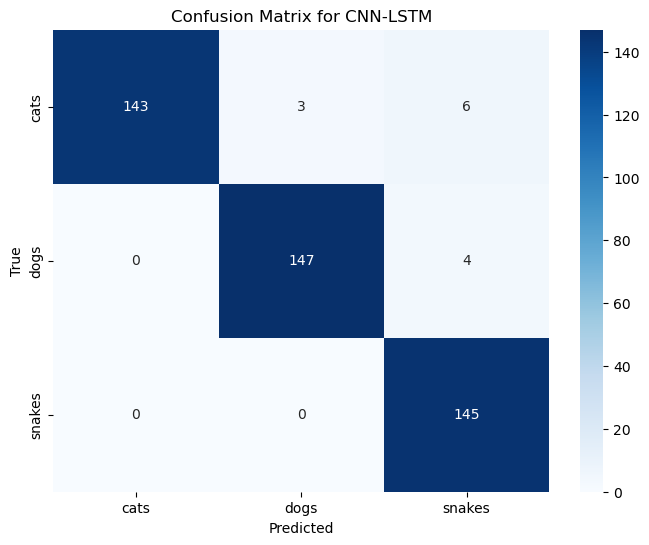

Classification Report:
              precision    recall  f1-score   support

        cats       1.00      0.94      0.97       152
        dogs       0.98      0.97      0.98       151
      snakes       0.94      1.00      0.97       145

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448



In [145]:


# Load the saved model
cnn_lstm_model = load_model("cnn_lstm_model.h5")

# Predict on the test data
test_generator.reset() 
predictions = cnn_lstm_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)  

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class names

# the Confusion Matrix
conf_matrix = confusion_matrix(true_classes[:len(predicted_classes)], predicted_classes)

# Visualizing Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN-LSTM')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_classes[:len(predicted_classes)], predicted_classes, target_names=class_labels))
